## Regression Problem: Wind Production Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the electricity production of windmills in France.

**Dataset:**  A csv file with 8 784 samples from the year 2016 is provided (on the course webpage). Each example contains three input features describing the weather at that time. We will use 6 000 examples as training set, 1 000 as validation set and the rest as test set.   
   * **Feature names**: FR_windspeed_10, FR_temperature, FR_radiation_direct_horizontal
   * **Target**: FR_wind_onshore_generation_actual

**NB:** new required libraries: `pandas`, `seaborn`.

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline

In [242]:
device = torch.device("cuda:0")

In [243]:
# Load data:
df = pd.read_csv("../../Datasets/FR_wind_predict_2016.csv", parse_dates=[0], index_col=0)

In [244]:
df.head()

,FR_wind_onshore_generation_actual,FR_windspeed_10m,FR_temperature,FR_radiation_direct_horizontal
utc_timestamp,,,,
2016-01-01 00:00:00+00:00,2082.0,2.86,5.571,0.0
2016-01-01 01:00:00+00:00,1690.0,2.68,5.415,0.0
2016-01-01 02:00:00+00:00,1414.0,2.51,5.288,0.0
2016-01-01 03:00:00+00:00,1200.0,2.45,5.177,0.0
2016-01-01 04:00:00+00:00,1000.0,2.35,5.131,0.0


In [245]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8783 entries, 2016-01-01 00:00:00+00:00 to 2016-12-31 22:00:00+00:00
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FR_wind_onshore_generation_actual  8783 non-null   float64
 1   FR_windspeed_10m                   8783 non-null   float64
 2   FR_temperature                     8783 non-null   float64
 3   FR_radiation_direct_horizontal     8783 non-null   float64
dtypes: float64(4)
memory usage: 343.1 KB


In [246]:
df.describe() # get more information

,FR_wind_onshore_generation_actual,FR_windspeed_10m,FR_temperature,FR_radiation_direct_horizontal
count,8783.000000,8783.000000,8783.000000,8783.000000
mean,2380.773312,4.042480,11.276523,90.074886
std,1793.890294,1.527457,6.966120,164.944171
min,53.000000,1.360000,-2.809000,0.000000
25%,1058.000000,2.950000,5.795000,0.000000
50%,1841.000000,3.670000,10.382000,0.722422
75%,3211.000000,4.840000,16.412500,99.896329
max,8620.000000,12.150000,31.917000,838.315937


### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

(0.0, 10000.0)

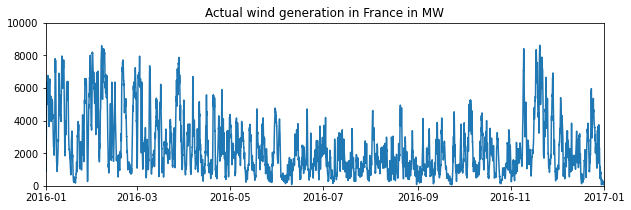

In [247]:

plt.figure(figsize=(10, 3))
plt.plot(df.index, df['FR_wind_onshore_generation_actual'])
plt.title('Actual wind generation in France in MW')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
plt.ylim(0, 10000)

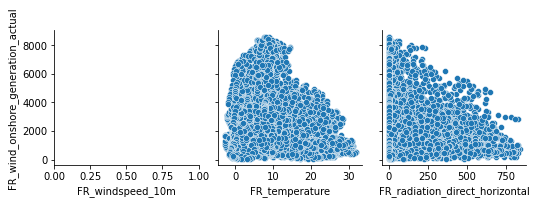

In [248]:
sns.pairplot(df, x_vars=['FR_windspeed_10m', 'FR_temperature', 'FR_radiation_direct_horizontal'], y_vars=['FR_wind_onshore_generation_actual'])

### Wind prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [249]:
normalized_df=(df-df.mean())/df.std()

In [250]:
X_wind = normalized_df[['FR_windspeed_10m', 'FR_temperature', 'FR_radiation_direct_horizontal']] # get the three features from the dataframe
y_wind = normalized_df["FR_wind_onshore_generation_actual"] # get the target values

In [251]:
X_train = X_wind.iloc[:6000]
y_train = y_wind.iloc[:6000]

X_val = X_wind.iloc[6000:7000]
y_val = y_wind.iloc[6000:7000]

X_test = X_wind.iloc[7000:]
y_test = y_wind.iloc[7000:]

In [252]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(3, 100)
        self.l2 = nn.Linear(100, 50)
        self.l3 = nn.Linear(50, 20)
        self.l4 = nn.Linear(20, 20)
        self.l5 = nn.Linear(20, 5)
        self.l6 = nn.Linear(5, 2)
        
    def forward(self, inputs):
        outputs = nn.functional.relu(self.l1(inputs))
        outputs = nn.functional.relu(self.l2(outputs))
        outputs = nn.functional.relu(self.l3(outputs))
        outputs = nn.functional.relu(self.l4(outputs))
        outputs = nn.functional.relu(self.l5(outputs))
        outputs = self.l6(outputs)
        return outputs

In [253]:
# Define hyper-parameters:
model = Model()
model.to(device)

# Choose the hyperparameters for training: 
num_epochs = 20
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

In [254]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float()) # creat the dataset.
val_set = TensorDataset(torch.from_numpy(np.array(X_val)).float(), 
                          torch.from_numpy(np.array(y_val)).float()) # creat the dataset.

In [255]:
def my_loss(y_pred, y_true, batch_size):
    logsig2_y = y_pred[0]
    mu_y = y_pred[1]
    value = 0
    n = batch_size
    for i in range(n):
        value += 1/2 * (np.log(2 * np.pi) + logsig2_y)
        value += 1 / (2 * torch.exp(logsig2_y)) * (y_true[i] - mu_y) ** 2
    return value

In [256]:
def train(num_epochs, batch_size, criterion, optimizer, model, train_dataset, val_dataset):
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size)

    
    for epoch in range(num_epochs):
        model.train()
        epoch_average_loss = 0.0
        for (X, y) in (train_dataloader):

            y_pre = model(X.to(device)).view(-1)
            # loss = criterion(y_pre, y)
            loss = my_loss(y_pre, y, batch_size)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
            
        print('Epoch [{}/{}], Loss_error: {:.4f}'.format(epoch+1, num_epochs,  epoch_average_loss))
        model.eval()
        with torch.no_grad():
            y_pre_val = model(torch.from_numpy(np.array(X_val)).float().to(device)).view(-1)
        error = my_loss(y_pre_val, torch.tensor(np.array(y_val)).float(), batch_size).item()
        print('The loss on validation set is:', error)
                

In [257]:
train(num_epochs, batch_size, criterion, optimizer, model, train_set, val_set)

Epoch [1/20], Loss_error: 14.5464
The loss on validation set is: 9.661707878112793
Epoch [2/20], Loss_error: 14.5089
The loss on validation set is: 10.282482147216797
Epoch [3/20], Loss_error: 14.4977
The loss on validation set is: 9.825495719909668
Epoch [4/20], Loss_error: 14.5047
The loss on validation set is: 9.351048469543457
Epoch [5/20], Loss_error: 14.5170
The loss on validation set is: 10.46243953704834
Epoch [6/20], Loss_error: 14.4782
The loss on validation set is: 10.120247840881348
Epoch [7/20], Loss_error: 14.5108
The loss on validation set is: 9.464336395263672
Epoch [8/20], Loss_error: 14.4401
The loss on validation set is: 10.504953384399414
Epoch [9/20], Loss_error: 14.4857
The loss on validation set is: 9.786434173583984
Epoch [10/20], Loss_error: 14.4786
The loss on validation set is: 9.942682266235352
Epoch [11/20], Loss_error: 14.4872
The loss on validation set is: 9.790390968322754
Epoch [12/20], Loss_error: 14.4914
The loss on validation set is: 9.88857460021972

#### Evaluate the Model on the validation set

In [258]:
# Calculate mean squared error on validation set
model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

RuntimeError: Tensor for argument #2 'mat1' is on CPU, but expected it to be on GPU (while checking arguments for addmm)

### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `FR_radiation_direct_horizontal` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.